# 第十八、十九、二十次课-评分作业
**此次作业<span style="color:red;">成绩计入总评</span>，总分11分，高于10分的部分视为附加题成绩**

**请将作业命名为<span style="color:red;">HW18-评分作业+姓名+学号.ipynb</span>, 并于<span style="color:red;">6月10日23:59前</span>提交**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
from matplotlib import pyplot as plt
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import torch 
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(0)
np.random.seed(0)

### 读取数据并划分数据集（勿更改代码）

In [2]:
def findFiles(path): 
    return glob.glob(path)
tags = []
X = []
y = []


def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return lines

for filename in findFiles('data/*.txt'):
    language = os.path.splitext(os.path.basename(filename))[0]
    if language not in tags:
        tags.append(language)
    lines = readLines(filename)
    for line in lines:
        X.append(line)
        y.append(language)

n_tags = len(tags)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =10, stratify = y)

## 前言：本次作业使用的数据集用来完成词性标注任务，提前观察数据集的特点，有利于完成后续的任务

# 一、隐马尔可夫模型（2分）

### 1.1 准备数据（0.5分）

In [3]:
from hmmlearn import hmm
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [4]:
# 提取特征
def extract_features(data):
    # TODO: 0.5分
    features = []
    vocabulary = {}
    index = 0
    for word in data:
        if word not in vocabulary:
            vocabulary[word] = index
            index += 1
        features.append(vocabulary[word])
    return np.array(features).reshape(-1, 1), len(features)
        
    
X_train_features, X_train_lengths = extract_features(X_train)
X_test_features, X_test_lengths = extract_features(X_test)

In [5]:
X_train_features.shape

(8509, 1)

### 1.2 使用HMM模型进行训练、预测（1分）

In [6]:
# 训练HMM模型
hmm_model = hmm.MultinomialHMM(n_components=n_tags, n_iter=300)
hmm_model.fit(X_train_features, X_train_lengths)

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


MultinomialHMM(n_components=14, n_iter=300,
               n_trials=array([   0,    1,    2, ..., 8506, 8507, 8508]),
               random_state=RandomState(MT19937) at 0x10A190C40)

In [7]:
# HMM预测
def hmm_predict(model, X, lengths):
    # TODO: 1分
    _, predicted_states = model.decode(X, lengths, algorithm="viterbi")
    return predicted_states
y_train_pred = hmm_predict(hmm_model, X_train_features, X_train_lengths)
y_test_pred = hmm_predict(hmm_model, X_test_features, X_test_lengths)

### 1.3 模型评估（0.5分）

In [8]:
from sklearn.metrics import accuracy_score
# 评估函数
def evaluate(y_true, y_pred):
    # TODO: 0.5分
    return accuracy_score(y_true, y_pred)
# HMM结果
print("HMM结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

HMM结果
train set accuracy: 0.0783
test set accuracy: 0.0691


## 二、RNN模型的应用（3分）

### 2.1 数据准备和预处理（0.5分）

### 字符的编码

本部分所有代码均可根据自己实现需要进行增删改，所给代码只是一种实现的参考模版。

In [9]:
# 统计字符
s = set()
for path in findFiles('data/*.txt'):
    f = open(path,"r")
    for word in f.readlines():
        for char in word:
            s.add(char)
    f.close()
all_letters = ""
for c in s:
    all_letters+=str(c)

n_letters = len(all_letters)

In [10]:
#function to create name representation

def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [11]:
#function to create lang representation

def nat_rep(lang):
    return torch.tensor([tags.index(lang)], dtype = torch.long)

In [12]:
#create a dataloader

def dataloader(batch_size, X_, y_):
    to_ret = []
    X = []
    for name in X_:
        X.append(name_rep(name))
    Y = torch.tensor([nat_rep(y) for y in y_])
    # TODO: 0.5分
    data = list(zip(X, Y))
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        batch_X, batch_y = zip(*batch)
        to_ret.append((list(batch_X), list(batch_y)))
    
    return to_ret

In [13]:
dataloader(10, X_train, y_train)[0][0][1].shape

torch.Size([8, 1, 73])

In [14]:
X_train[1]

'hardware'

### 2.2 RNN网络的搭建（1分）

In [15]:
class RNN_net(nn.Module):
    # TODO: 1分
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()

        self.hidden_size = hidden_size
        self.input2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.input2output = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), dim=1)
        hidden = torch.tanh(self.input2hidden(combined))
        output = self.softmax(self.input2output(combined))
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

### 2.3 模型的训练（1分）

In [16]:
# function to train the data

def train_step(net, opt, criterion, batch_size):
    my_dataloader = dataloader(batch_size, X_train, y_train)
    total_loss = 0
    batches = random.choices(my_dataloader, k=5) # 每次随机选择5个batch用于训练
    for batch in batches:
        X = batch[0]    # batch_size * _ * 1 * 73
        y = torch.tensor(batch[1])
        net.zero_grad()
        for i in range(len(X)): # 循环所有单词
            word = X[i] # _ * 1 * 73
            hidden = net.init_hidden()
            for j in range(word.shape[0]): # 遍历所有字符
                ch = word[j, :, :]  # 1 * 73
                output, hidden = net(ch, hidden)
            output = output.squeeze(0)
            loss = criterion(output, y[i])
            loss.backward()
            total_loss += loss.item()
        
        opt.step() # 注意在一个batch完成后再进行梯度下降
        
    return total_loss / (5 * batch_size)

In [17]:
def train(net, lr = 0.01, steps = 100, batch_size = 10, momentum = 0.9, freq = 5):

    # TODO: 0.5分
    loss_arr = np.zeros(steps)
    opt = optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    #iterate through all the batches
    for i in range(steps):
        loss_arr[i] = train_step(net, opt, criterion, batch_size)
        if (i+1)%freq==0: 
            print("Iteration number:", i + 1,'Loss:', round(loss_arr[i],4))

    plt.figure()
    plt.plot(loss_arr, "-*")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print("\n\n")

Iteration number: 5 Loss: 1.8339
Iteration number: 10 Loss: 1.4107
Iteration number: 15 Loss: 1.2308
Iteration number: 20 Loss: 1.0521
Iteration number: 25 Loss: 1.0071
Iteration number: 30 Loss: 1.0272
Iteration number: 35 Loss: 0.9403
Iteration number: 40 Loss: 0.9776
Iteration number: 45 Loss: 0.9098
Iteration number: 50 Loss: 0.9165
Iteration number: 55 Loss: 0.8221
Iteration number: 60 Loss: 0.742
Iteration number: 65 Loss: 0.8606
Iteration number: 70 Loss: 0.7898
Iteration number: 75 Loss: 0.7446
Iteration number: 80 Loss: 0.8072
Iteration number: 85 Loss: 0.7144
Iteration number: 90 Loss: 0.7658
Iteration number: 95 Loss: 0.7021
Iteration number: 100 Loss: 0.7579


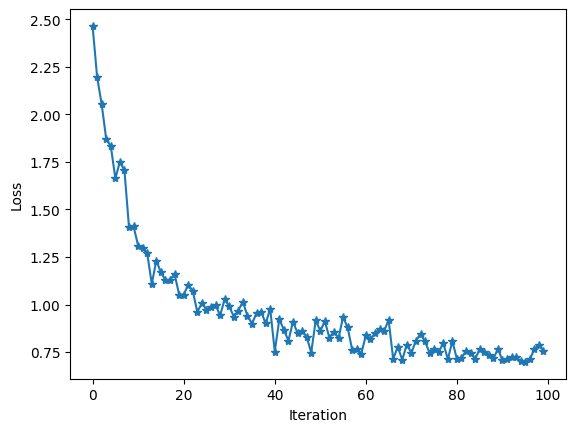

In [18]:
# RNN训练
n_hidden = 128
rnn_net = RNN_net(n_letters, n_hidden, n_tags)
train(rnn_net, lr = 0.005, steps = 100, batch_size = 128)

### 2.4 模型的评估（0.5分）

In [19]:
def infer(net, name):
    net.eval()
    name_ohe = name_rep(name)
    hidden = net.init_hidden()

    for i in range(name_ohe.size()[0]):
        output, hidden = net(name_ohe[i], hidden)

    return output

In [20]:
#create a function to evaluate model

def eval_test(net):
     correct = 0
     for i in range(len(X_test)):
        name,lang = X_test[i],y_test[i]
        name_ohe = name_rep(name)
        lang_rep = nat_rep(lang)
        output = infer(net, name) 
        val, indices = output.topk(1) 
    
        if indices == lang_rep:
            correct += 1
     accuracy = correct/len(X_test)

     return accuracy

In [21]:
#create a function to evaluate model

def eval_train(net):
     # TODO: 0.5分
     correct = 0
     for i in range(len(X_train)):
          name,lang = X_train[i],y_train[i]
          name_ohe = name_rep(name)
          lang_rep = nat_rep(lang)
          output = infer(net, name) 
          val, indices = output.topk(1) 
    
          if indices == lang_rep:
               correct += 1
     accuracy = correct/len(X_train)
     return accuracy

In [22]:
print("rnn结果")
print("train set accuracy:"+str(round(eval_train(rnn_net),4)))
print("test set accuracy:"+str(round(eval_test(rnn_net),4)))

rnn结果
train set accuracy:0.7678
test set accuracy:0.7364


## 三、预训练模型的使用（3分）

### 3.1 数据准备和预处理，模型的导入（0.5分）

In [23]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# 初始化BERT模型和tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    device = "mps" if torch.backends.mps.is_available() else "cpu"
bert_model = bert_model.to(device)

### 3.2 使用BERT进行特征提取（1分）

In [24]:
# 提取BERT特征

def extract_bert_features(data):
    features = []
    # TODO: 1分
    inputs = tokenizer(data, return_tensors='pt', padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = bert_model(**inputs)
    cls_token_features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    features.extend(cls_token_features)
    return features
    
# 提取训练集和测试集的特征
X_train_features = extract_bert_features(X_train)
X_test_features = extract_bert_features(X_test)

In [25]:
# 标签编码
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### 3.3 使用一个分类器对提取好的特征进行分类（1分）

In [26]:
# TODO: 1分
clf = LogisticRegression(max_iter=1000)
clf = clf.fit(X_train_features, y_train_encoded)

In [27]:
# 预测
y_train_pred = clf.predict(X_train_features)
y_test_pred = clf.predict(X_test_features)

### 3.4 评估结果（0.5分）

In [28]:
# 评估函数
def evaluate(y_true, y_pred):
    # TODO: 0.5分
    return accuracy_score(y_true, y_pred)

# BERT结果
print("BERT结果")
print("train set accuracy:", round(evaluate(y_train_encoded, y_train_pred), 4))
print("test set accuracy:", round(evaluate(y_test_encoded, y_test_pred), 4))

BERT结果
train set accuracy: 0.907
test set accuracy: 0.7904


## 四、三种模型的总结与分析（1分）

请简述这次作业使用的数据集在三种模型下的表现产生显著差异的原因，并且给出能够提高HMM表现的数据加强方式。

### 效果对比
本次作业分别使用了HMM、RNN和BERT三种模型在给定数据集上完成了词性标注的任务。从效果来看，HMM在该任务中的表现不佳，训练集与测试集上的准确率均只有7%左右。相比之下，RNN经过一定的训练后，其测试集上的表现和BERT相差不大，但BERT在提取训练集特征的能力上更强一些。

### 原因分析
HMM表现不佳的主要原因是特征提取过程过于简单。我们仅仅将每个单词在词汇表中的索引作为特征进行训练，这种特征中没有包含任何语义信息。此外，HMM在处理任务时主要依赖于特征提取和序列长度，而数据中的单词之间并不存在语义上的上下文关系，这导致了词性预测效果不佳。

RNN通过隐状态的传递，能够捕捉单词中字符的次序关系，并从中学习到一定的语义信息，因此在词性预测任务中表现较好。

BERT在训练集上的表现良好，显示了其强大的语义信息提取能力。这主要归功于其作为预训练大模型，可以利用大规模语料库中的上下文信息进行特征提取，从而获取丰富的语义信息。然而，由于BERT模型在本次任务中没有经过下游任务的微调，因此在测试集上的表现与RNN相差不大，泛化能力略显不足。

### 能够提高HMM表现的数据加强方式
#### 增加训练数据量
更多的数据可以帮助HMM更好地估计转移概率和观测概率，从而提高模型的性能。 
#### 在特征中引入上下文信息
在现有特征中加入上下文信息，使HMM能够捕捉到目标单词与其他单词之间的关联信息。
-   利用窗口方法，将目标单词及其邻近单词的组合作为特征。
-   特征工程：增加特征的多样性和丰富性，如加入词频、词根、前缀、后缀等特征，帮助HMM更好地进行分类。
#### 数据预处理
进行数据清洗和规范化处理，去除噪声和异常数据，提高数据质量，确保特征的可靠性。